# Data Science Festival x ASOS
## Build and Deploy a Recommender System in 3 Hours.

Code from the Data Science Festival 2020, ASOS Fashion Recommender Workshop. I've created a new notebook which has been simplified to only use the essential code and so I can experiment with different parameters

# Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os

# Import training data

In [2]:
train = pd.read_parquet("https://raw.githubusercontent.com/ASOS/dsf2020/main/dsf_asos_train_with_alphanumeric_dummy_ids.parquet")
valid = pd.read_parquet("https://raw.githubusercontent.com/ASOS/dsf2020/main/dsf_asos_valid_with_alphanumeric_dummy_ids.parquet")
dummy_users = pd.read_csv("https://raw.githubusercontent.com/ASOS/dsf2020/main/dsf_asos_dummy_users_with_alphanumeric_dummy_ids.csv", header=None).values.flatten().astype(str)
products = pd.read_csv("https://raw.githubusercontent.com/ASOS/dsf2020/main/dsf_asos_productIds.csv", header=None).values.flatten().astype(int)

# Define Model


In [3]:
class SimpleRecommender(tf.keras.Model):
    def __init__(self, dummy_users, products,length_of_embedding):
        super(SimpleRecommender, self).__init__() #Because it's a subclass of tf.keras.model
        self.products = tf.constant(products, dtype=tf.int32) #Create tensor object of products
        self.dummy_users = tf.constant(dummy_users, dtype=tf.string) #Create tensor object of users
        self.dummy_user_table = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(self.dummy_users, range(len(dummy_users))), -1) #Create hash table for User IDs and their index
        #Parse in list of User IDs and the total number of users to get mapping from user IDs to index in embedding
        # -1 is the default value to return if you look for a user that doesn't exist in the hash table
        self.product_table = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(self.products, range(len(products))), -1) #Create hash table for Product IDs and their index
        
        self.user_embedding = tf.keras.layers.Embedding(len(dummy_users), length_of_embedding) #Embedding layer for user which, for each user index, creates a list of random numbers
        self.product_embedding = tf.keras.layers.Embedding(len(products), length_of_embedding) #Embedding layer for product
        
        self.dot= tf.keras.layers.Dot(axes=-1) # Dot product layer, Last set of axes for both inputs

    def call(self,inputs):
        user = inputs[0] #Expect first input to be user
        products=inputs[1] #and second input to be products

        user_embedding_index=self.dummy_user_table.lookup(user) #Look up user index
        product_embedding_index=self.product_table.lookup(products) #Look up product indexes

        user_embedding_values=self.user_embedding(user_embedding_index) #Get user embedding values using the user index
        product_embedding_values=self.product_embedding(product_embedding_index) #Do the same for products

        return tf.squeeze(self.dot([user_embedding_values,product_embedding_values]),axis=1) #Calculate dot product between user and product embeddings
        #Use tf.squeeze to remove needless dimension of output tensor

    @tf.function #Takes product vectors and finds which products are most similar to each other
    #Gives a you might also like list for each product
    def call_item_item(self, product):
        product_x = self.product_table.lookup(product) #Lookup hash table index for product input
        pe = tf.expand_dims(self.product_embedding(product_x), 0) #Get product embedding
        
        #Get all product mebddings
        all_pe = tf.expand_dims(self.product_embedding.embeddings, 0)#note this only works if the layer has been built!
        scores = tf.reshape(self.dot([pe, all_pe]), [-1])#Use dot layer to find dot product between input product embedding and rest of the product embedddings
        
        top_scores, top_indices = tf.math.top_k(scores, k=100) #Get indices of the top 100 products and their corresponding scores
        top_ids = tf.gather(self.products, top_indices) #Use indices to get product IDs
        return top_ids, top_scores

In [4]:
sr1=SimpleRecommender(dummy_users,products,15)

In [5]:
#Calculate output values for 2 users with different sets of products
sr1([tf.constant([['pmfkU4BNZhmtLgJQwJ7x'],['UDRRwOlzlWVbu7H8YCCi']]),
     tf.constant([[8650774,9306139, 9961521],[12058614, 12058615, 11927550]])])

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-0.000961  , -0.00494935, -0.00099695],
       [ 0.00156072,  0.00066998,  0.00199211]], dtype=float32)>

# Creating a dataset

In [6]:
train

dummyUserId  productId
0       b'PIXcm7Ru5KmntCy0yA1K'   10524048
1       b'd0RILFB1hUzNSINMY4Ow'    9137713
2       b'Ebax7lyhnKRm4xeRlWW2'    5808602
3       b'vtigDw2h2vxKt0sJpEeU'   10548272
4       b'r4GfiEaUGxziyjX0PyU6'   10988173
...                         ...        ...
165037  b'7Eom5Ancozj01ozGxAMK'    9071435
165038  b'zi9vZETHqSIZK0TM2nZc'   10413104
165039  b'fVCveec9P946asY5wqGm'    9859881
165040  b'VJtfpw602SZHh2qwarK4'   10809487
165041  b'D8BlXaKnJHXmxgwfSZzE'    8752491

[165042 rows x 2 columns]

First create a TensorFlow dataset from the user purchase pairs


In [7]:
dummy_user_tensor = tf.constant(train[["dummyUserId"]].values, dtype=tf.string) #Create constant tensor of user IDs
product_tensor = tf.constant(train[["productId"]].values, dtype=tf.int32) #Same for products

dataset = tf.data.Dataset.from_tensor_slices((dummy_user_tensor, product_tensor)) #Create Tensorflow dataset from this
for x, y in dataset:
    print(x)
    print(y)
    break

tf.Tensor([b'PIXcm7Ru5KmntCy0yA1K'], shape=(1,), dtype=string)
tf.Tensor([10524048], shape=(1,), dtype=int32)


Don't just want to use one product purchased to get a score, because we don't know exactly what the score means. What value is a good score? What is a really good score? etc.

For each purchase let's sample a number of products that the user did not purchase. Then the model can score each of the products and we will know we are doing a good job if the product with the highest score is the product that the user actually purchased. Can see how often our model predicts the purchased product as rank number 1

In [8]:
class Mapper():
    
    def __init__(self, possible_products, num_negative_products): #Inputs of a list of possible products and the number of negative products you want to use

        self.num_possible_products = len(possible_products)
        self.possible_products_tensor = tf.constant(possible_products, dtype=tf.int32) #Create tensorflow constant of product IDs
        
        self.num_negative_products = num_negative_products
        self.y=tf.one_hot(0,depth=num_negative_products+1) #Create one hot object with a 1 at the first index, as the actual purchased product will be at the first index
        #Length of the one hot vector is the number of negative products being used + 1 for the single positive product

    def __call__(self, user, product):

        random_negatives_index=tf.random.uniform((self.num_negative_products,),minval=0,maxval=self.num_possible_products, dtype=tf.int32) #Create indexes for sampling random negative products
        negatives=tf.gather(self.possible_products_tensor,random_negatives_index) #Sample random negative products
        candidates=tf.concat([product,negatives],axis=0) #Concatenate the actual product with the random negative products to create list of candidates to input to model
        return (user, candidates), self.y

In [9]:
dataset = tf.data.Dataset.from_tensor_slices((dummy_user_tensor, product_tensor)).map(Mapper(products,10))
dataset
for (u,c),y in dataset:
  print(u)
  print(c)
  print(y)
  break
    

tf.Tensor([b'PIXcm7Ru5KmntCy0yA1K'], shape=(1,), dtype=string)
tf.Tensor(
[10524048 11745477 10922584 13107389 10328866 12044513 10200130 12987266
  8381408 10866434 12991679], shape=(11,), dtype=int32)
tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(11,), dtype=float32)


Now define a function to create a dataset

In [13]:
def get_dataset(df, products, num_negative_products):
    dummy_user_tensor=tf.constant(df[["dummyUserId"]].values,dtype=tf.string) #Create tensor from user IDs
    product_tensor=tf.constant(df[["productId"]].values,dtype=tf.int32) #Create tensor from product IDs

    dataset=tf.data.Dataset.from_tensor_slices((dummy_user_tensor,product_tensor)) #Create dataset from these slices
    dataset=dataset.map(Mapper(products,num_negative_products)) #Use mapper function to output user ID, candidate values and one hot vector (y)
    dataset=dataset.batch(1024) #Put into batches so we can learn from a large number of users at a time
    return dataset

# Train Model

In [32]:
model=SimpleRecommender(dummy_users,products,15)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.SGD(learning_rate=100),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

model.fit(get_dataset(train,products,100),validation_data=get_dataset(valid,products,100),epochs=5)

Epoch 1/5
162/162 [==============================] - 10s 63ms/step - loss: 4.6151 - categorical_accuracy: 0.0131 - val_loss: 4.6152 - val_categorical_accuracy: 0.0176
Epoch 2/5
162/162 [==============================] - 10s 64ms/step - loss: 4.6120 - categorical_accuracy: 0.0820 - val_loss: 4.6149 - val_categorical_accuracy: 0.0460
Epoch 3/5
162/162 [==============================] - 12s 72ms/step - loss: 4.6009 - categorical_accuracy: 0.1915 - val_loss: 4.6094 - val_categorical_accuracy: 0.0718
Epoch 4/5
162/162 [==============================] - 10s 61ms/step - loss: 4.5321 - categorical_accuracy: 0.2454 - val_loss: 4.5651 - val_categorical_accuracy: 0.0960
Epoch 5/5
162/162 [==============================] - 10s 62ms/step - loss: 4.3176 - categorical_accuracy: 0.2475 - val_loss: 4.4297 - val_categorical_accuracy: 0.1086


In [29]:
test_product = 11698965

In [30]:
print("Recs for item {}: {}".format(test_product, model.call_item_item(tf.constant(test_product, dtype=tf.int32))))

Recs for item 11698965: (<tf.Tensor: shape=(100,), dtype=int32, numpy=
array([ 7880723, 10994983, 10333386, 11541077,  8661992, 11409896,
        9189046, 10909750,  9071435, 10965260,  8907440, 12084517,
       12175091, 11855304, 11113894,  9407068,  9361601, 10567161,
       11230891, 11586994, 10560450, 10571852, 13329218, 11977253,
       11910031, 10282780, 11827084, 10684960,  8589571, 10714630,
       11448828, 11719814,  8873154,  9375207, 12406740, 12148915,
       10782285, 11890074,  9894339,  8927246, 11696754,  8386464,
       11462828,  9180236, 10598281, 10072124, 12741691, 10441130,
       10430039, 10139670, 12507814,  9693744, 10247231, 10300595,
       11264278,  9565144,  6486217, 11187698,  9529393,  9061175,
       10231893, 11574405, 10352373,  7908164,  8877710, 12145899,
       10840111,  9010740, 10649764, 11521817,  9091460, 11501183,
       10448772, 12966846,  9045560, 11931493, 11866646, 11457138,
       13161940, 12192248, 11612354, 12733534, 12591553, 1

Now test with a higher number of epochs

In [34]:
model=SimpleRecommender(dummy_users,products,15)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.SGD(learning_rate=100),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

model.fit(get_dataset(train,products,100),validation_data=get_dataset(valid,products,100),epochs=20)

Epoch 1/20
162/162 [==============================] - 10s 60ms/step - loss: 4.6151 - categorical_accuracy: 0.0132 - val_loss: 4.6151 - val_categorical_accuracy: 0.0187
Epoch 2/20
162/162 [==============================] - 10s 60ms/step - loss: 4.6120 - categorical_accuracy: 0.0832 - val_loss: 4.6146 - val_categorical_accuracy: 0.0477
Epoch 3/20
162/162 [==============================] - 10s 59ms/step - loss: 4.5980 - categorical_accuracy: 0.1924 - val_loss: 4.6033 - val_categorical_accuracy: 0.0795
Epoch 4/20
162/162 [==============================] - 9s 57ms/step - loss: 4.5164 - categorical_accuracy: 0.2389 - val_loss: 4.5342 - val_categorical_accuracy: 0.1037
Epoch 5/20
162/162 [==============================] - 9s 58ms/step - loss: 4.2788 - categorical_accuracy: 0.2355 - val_loss: 4.3761 - val_categorical_accuracy: 0.1131
Epoch 6/20
162/162 [==============================] - 9s 59ms/step - loss: 3.9333 - categorical_accuracy: 0.2503 - val_loss: 4.2740 - val_categorical_accuracy: 0.

As you can see, past 5 epochs the model begins to perform worse on the validation set, with validation accuracy gradually decreasing. Training set accuracy, on the other hand, is gradually increasing. Indicating that the higher number of epochs is may be causing overfitting

In [35]:
print("Recs for item {}: {}".format(test_product, model.call_item_item(tf.constant(test_product, dtype=tf.int32))))

Recs for item 11698965: (<tf.Tensor: shape=(100,), dtype=int32, numpy=
array([ 9320171, 10327202,  9094134, 10245780, 10373595, 10490457,
        9708846,  9025892, 11464603, 12303943, 10358063, 10490474,
        9561430, 12009602, 10584273,  7830952,  9903983, 10523177,
       10138462, 11658125, 10853923, 11239828,  9991638, 10594200,
       10490442, 11392796,  9906001, 10439338, 11187221, 10211317,
        9912128, 11161104, 12961061,  9191754,  9777705,  8132002,
       11161105,  8317562,  8640569, 11677432,  8589571,  9375209,
       10551234, 10364268, 11593059, 10452019, 10702429, 10884965,
        9818480,  8853625, 10252928, 10379216, 10497080, 11374225,
       10321189,  8439668, 12110501, 10208025, 12139209, 10818311,
        9605938, 10672901,  9441029, 11305230, 10930866, 11028490,
       11138439,  9123512, 11730173, 10200133, 10566516,  9968613,
       11513688, 10364265, 10893005, 13167324, 10082546,  8907441,
       11593680, 10389084, 10634180, 10965276, 12080395,  

In [45]:
model=SimpleRecommender(dummy_users,products,15)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

model.fit(get_dataset(train,products,100),validation_data=get_dataset(valid,products,100),epochs=20)

Epoch 1/20
162/162 [==============================] - 11s 68ms/step - loss: 4.6151 - categorical_accuracy: 0.0098 - val_loss: 4.6151 - val_categorical_accuracy: 0.0098
Epoch 2/20
162/162 [==============================] - 11s 65ms/step - loss: 4.6131 - categorical_accuracy: 0.0398 - val_loss: 4.6151 - val_categorical_accuracy: 0.0177
Epoch 3/20
162/162 [==============================] - 11s 65ms/step - loss: 4.6103 - categorical_accuracy: 0.1042 - val_loss: 4.6149 - val_categorical_accuracy: 0.0278
Epoch 4/20
162/162 [==============================] - 10s 64ms/step - loss: 4.6062 - categorical_accuracy: 0.1782 - val_loss: 4.6142 - val_categorical_accuracy: 0.0398
Epoch 5/20
162/162 [==============================] - 11s 67ms/step - loss: 4.5998 - categorical_accuracy: 0.2344 - val_loss: 4.6122 - val_categorical_accuracy: 0.0508
Epoch 6/20
162/162 [==============================] - 10s 65ms/step - loss: 4.5901 - categorical_accuracy: 0.2700 - val_loss: 4.6079 - val_categorical_accuracy:

In [46]:
print("Recs for item {}: {}".format(test_product, model.call_item_item(tf.constant(test_product, dtype=tf.int32))))

Recs for item 11698965: (<tf.Tensor: shape=(100,), dtype=int32, numpy=
array([11724744, 12107593,  9063966,  8636629, 12899073, 10528723,
        7732825, 12247071, 10388476,  9326979, 10754249,  8912697,
       13080567,  8692073,  9131774,  8701479, 13048384, 12663814,
       13268560, 10559132, 10530830, 11620583, 10234604, 10938515,
       11075314, 11230129, 10779392, 11361721, 12881384, 11194184,
       13031762,  9183607,  7383953,  9812197,  8913495, 13150681,
       11181915, 11656056, 12054230,  8900587, 12510736, 11731066,
       13104083, 10780902, 10157215,  8986915, 10742929, 12535079,
        9120845, 11727427, 11640008, 11222075,  8862057,  8435009,
        8152120, 10769218, 11865158, 10893335,  9305555, 10716048,
        9307976, 11782920, 13043723,  8666584, 11470062,  9218131,
       12673848, 11721115, 10220966,  9094128, 12595485, 13104103,
        8996914,  8978982, 11428449,  9554542, 12631631, 11705970,
       12388702,  8178095, 11751176,  9021095, 11049759, 1

Using the RMSProp optimizer seems to improve upon just using stochastic gradient descent by stopping overfitting from ocurring and giving a slightly higher final accuracy. Next I will look at the top recommended product for each of these model tests. First is the image of the product I want recommendations for

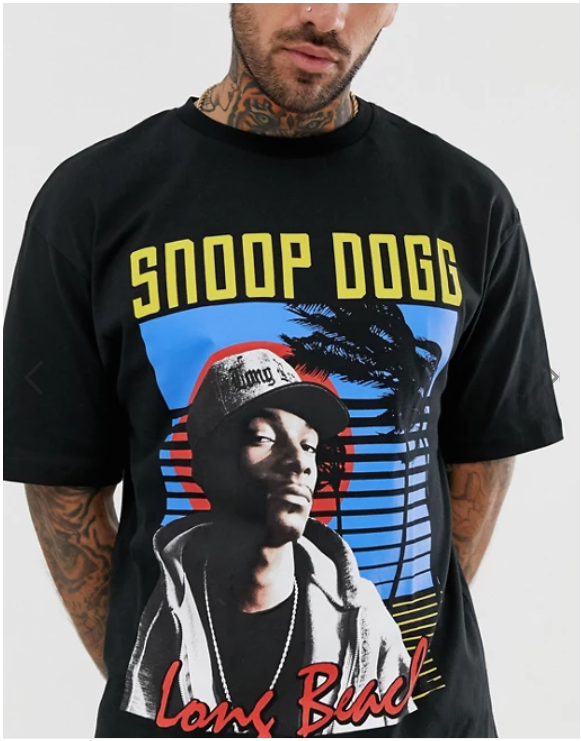

Next the product recommended by the model using 5 epochs and SGD, a pair of white socks. This isn't particularly like a black t-shirt, but it is a probably a very common purchase and something a person may wear with a black t-shirt. The same, I would say, applies to the black jacket and the blue t-shirt. They are relatively similar products stylistically and I could imagine a user buying them together. Overall, these are decent recommendations, in my opinion

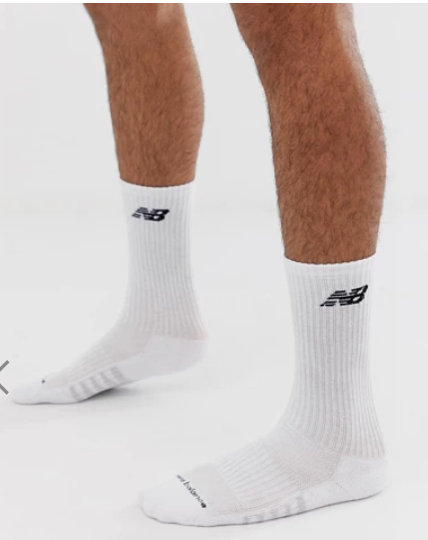

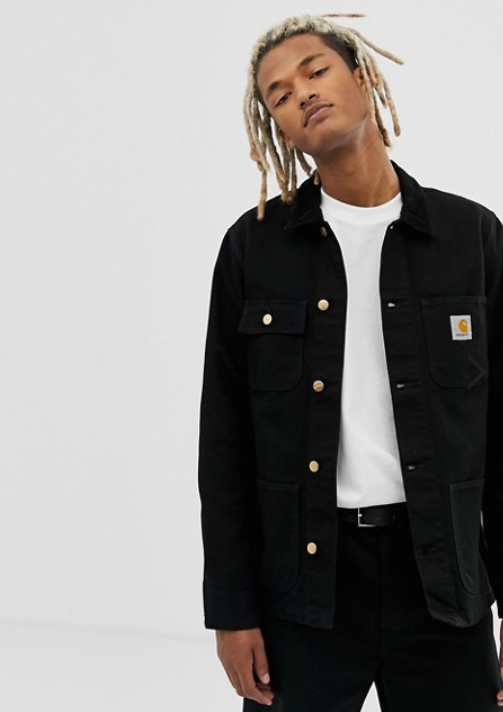

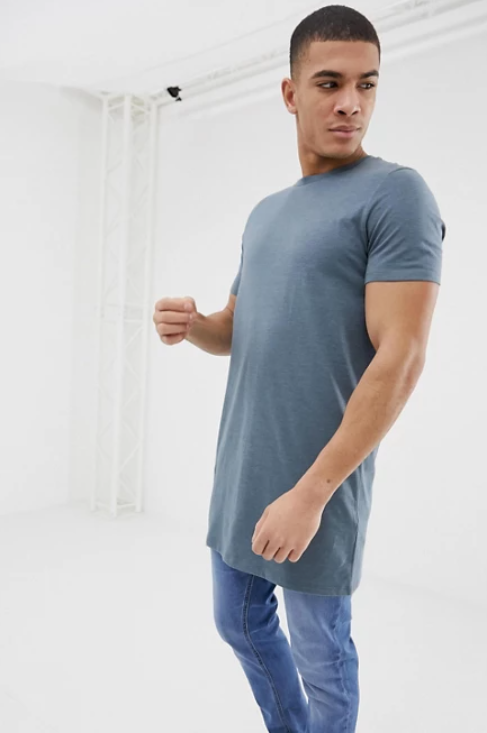

Next, the results from the model using 20 epochs and SGD. The model recommends two black tops and a pair of shoes. The two black tops are very similar to each other but I would say they are actually a very different style to the original product. Although the original product is a black top, like these two, it is a graphic t-shirt, whereas these are totally plain and with deep necks/v-necks. Additionally they are both plus size products which the original t-shirt was not. The shoes, in my opinion, are also not something I would expect someone who wore the graphic t-shirt to wear with it. I would say these are quite poor recommendations, which is expected as the model was overfitting

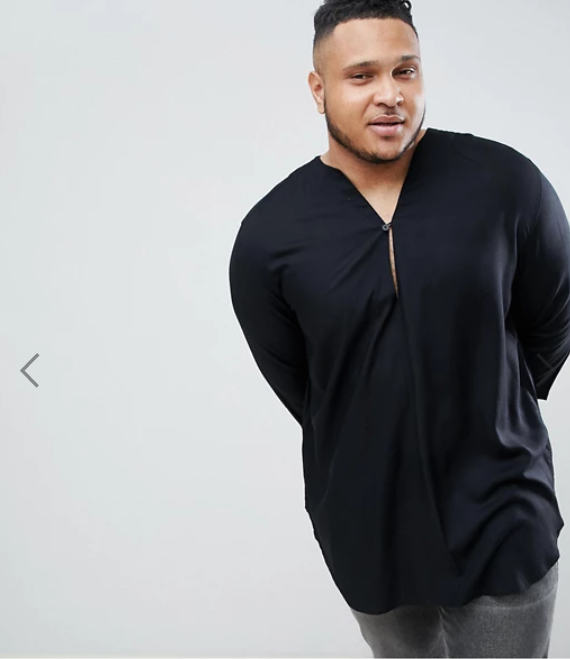

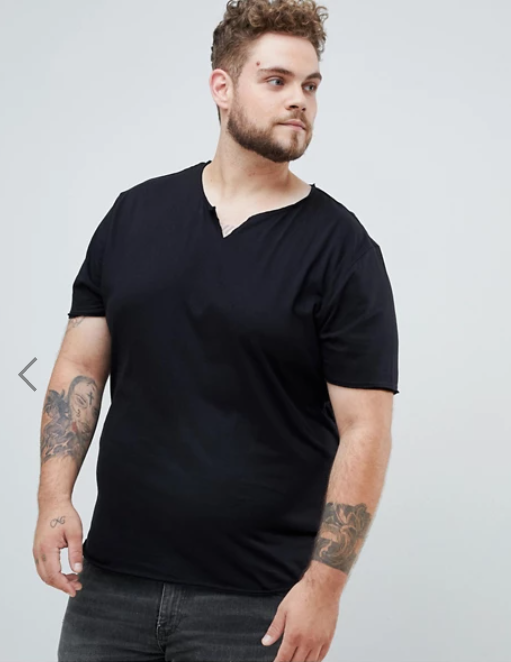

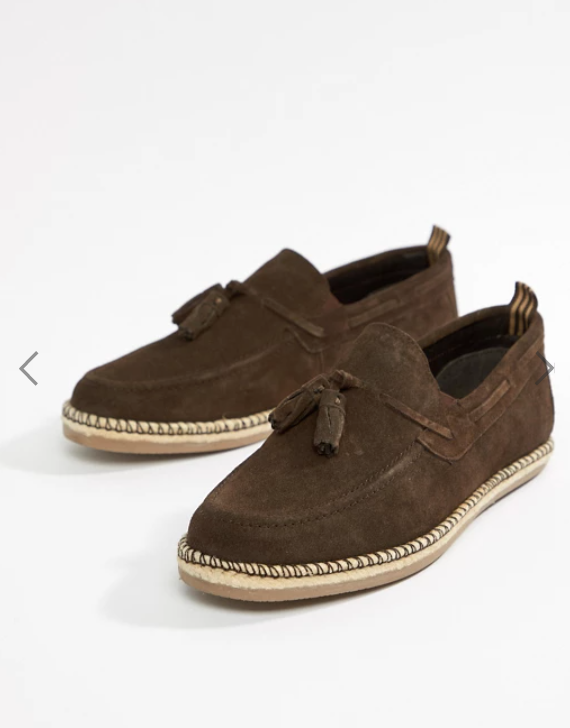

Finally, the model which used 20 epochs and RMSProp as an optimizer. The top product's page no longer existed so I had to use 2nd, 3rd and 4th top products. I don't have a lot to say about these recommendations. They include a purple hoodie, a white striped t-shirt and a denim jacket. These all seem very reasonable recommendations for the someone who would purchase the black graphic t-shirt and fit in with the style of it. It's hard to quantify it (other than validation accuracy), but in my opinion, these were the best recommendations out of the three models

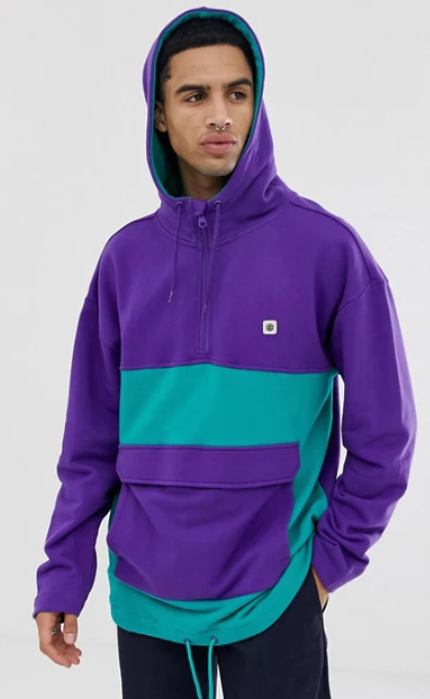

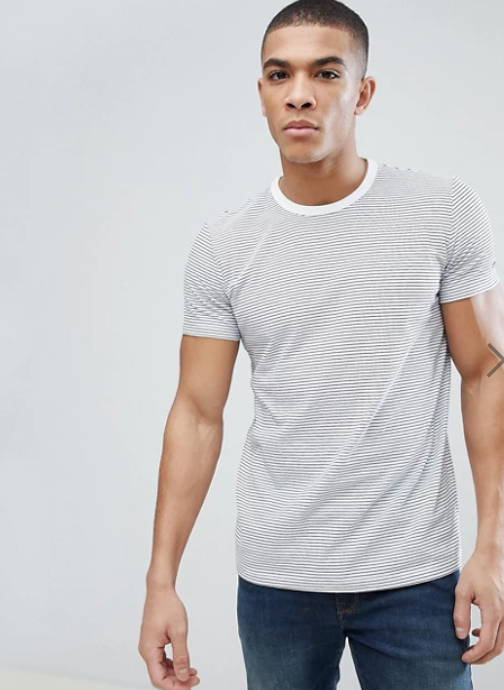

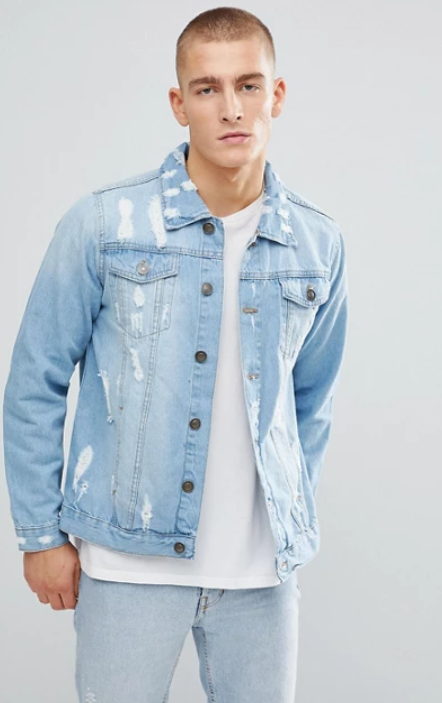